In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, box

from libpysal import weights
import matplotlib.pyplot as plt
import networkx as nx

fips_df = pd.read_csv("state_and_county_fips_master.csv")
fips_df = fips_df[fips_df["state"].isin(["MD", "DC", "VA"])]
fips_df["code"] = fips_df["fips"].apply(lambda a: str(a)[-3:])
dc_codes = fips_df[fips_df["name"].isin(["District of Columbia"])]["code"]
md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(["Prince George's County", "Montgomery County"])]["code"]
va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city", "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"])]["code"]

C:\Users\srjnk\AppData\Local\Temp\ipykernel_16048\1049747349.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  md_codes = fips_df[fips_df["state"] == "MD"][fips_df["name"].isin(["Prince George's County", "Montgomery County"])]["code"]
C:\Users\srjnk\AppData\Local\Temp\ipykernel_16048\1049747349.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  va_codes = fips_df[fips_df["state"] == "VA"][fips_df["name"].isin(["Arlington County", "Alexandria city", "Fairfax County", "Fairfax city", "Falls Church city", "Loudoun County", "Prince William County", "Manassas city", "Manassas Park city"])]["code"]


In [50]:
def get_points(df, extremities, layers=6):
    ids = []
    if layers <= 0:
        return ids
    if df.shape[0] < 2:
        return ids
    df_sorted = df.sort_values("point_likelihood",ascending=False)
    top_point = df_sorted.iloc[1]
    ids.append(top_point.SID)
    ex_bl = [extremities[0], extremities[1], top_point["INTPTLON20"], top_point["INTPTLAT20"]]
    df_bl = df.iloc[df.sindex.query(box(*ex_bl))] # bottom left
    ex_br = [top_point["INTPTLON20"], extremities[1], extremities[2], top_point["INTPTLAT20"]]
    df_br = df.iloc[df.sindex.query(box(*ex_br))] # bottom right
    ex_tl = [extremities[0], top_point["INTPTLAT20"], top_point["INTPTLON20"], extremities[3]]
    df_tl = df.iloc[df.sindex.query(box(*ex_tl))] # top left
    ex_tr = [top_point["INTPTLON20"], top_point["INTPTLAT20"], extremities[2], extremities[3]]
    df_tr = df.iloc[df.sindex.query(box(*ex_tr))] # top right
    ids += get_points(df_bl, ex_bl, layers-1) + get_points(df_br, ex_br, layers-1) + get_points(df_tl, ex_tl, layers-1) + get_points(df_tr, ex_tr, layers-1)
    return ids

In [3]:
md_df = gpd.read_file("md/tl_2023_24_tabblock20.shp")
md_df = md_df[md_df["COUNTYFP20"].isin(md_codes.to_list())]
va_df = gpd.read_file("va/tl_2023_51_tabblock20.shp")
va_df = va_df[va_df["COUNTYFP20"].isin(va_codes.to_list())] 
dc_df = gpd.read_file("dc/tl_2023_11_tabblock20.shp")
df = pd.concat([md_df, va_df, dc_df])

In [29]:
df.to_crs("EPSG:4326",inplace=True)
df["SID"] = df.index
df["INTPTLON20"] = df["INTPTLON20"].apply(lambda a: float(a))
df["INTPTLAT20"] = df["INTPTLAT20"].apply(lambda a: float(a))
# add NEIGHBORS column
df["NEIGHBORS"] = None
extremities = [df["INTPTLON20"].min(), df["INTPTLAT20"].min(), df["INTPTLON20"].max(), df["INTPTLAT20"].max()]
df["transit_potential"] = np.log(df['POP20']/(df['ALAND20'] + df['AWATER20'])*1000 + 1)

for index, country in df.iterrows():   
    break
    # get 'not disjoint' countries
    neighbors = df[~df.geometry.disjoint(country.geometry)].SID.tolist()

    # remove own name of the country from the list
    neighbors = [ name for name in neighbors if country.SID != name ]

    # add names of neighbors as NEIGHBORS value
    df.at[index, "NEIGHBORS"] = neighbors
    
#df["point_likelihood"] = [df.loc[i]["transit_potential"] - (df.loc[df.NEIGHBORS.loc[i]]["transit_potential"].mean()) for i in range(1, df.shape[0] + 1)]

In [ ]:
#df["point_likelihood"] = df["transit_potential"]
#l = list(set(get_points(df, extremities)))
points = gpd.GeoDataFrame(df[df['SID'].isin(l)]).to_crs("EPSG:4326")
#points["geometry"] = points.apply(lambda a: Point(a["INTPTLAT20"],a["INTPTLAT20"]),axis=1)

,index,geometry
0,546,POINT (-77.27204 39.24762)
1,731,POINT (-77.23508 39.1214)
2,819,POINT (-77.23973 39.12704)
3,866,POINT (-77.19677 39.11361)
4,930,POINT (-77.26547 39.24386)
...,...,...
336,5386,POINT (-77.0111 38.90459)
337,5392,POINT (-77.00633 38.91592)
338,5832,POINT (-77.02459 38.92025)
339,5868,POINT (-76.98399 38.92032)


In [82]:
#df_points = gpd.GeoDataFrame(geometry=points.centroid)
#knn3 = weights.Gabriel.from_dataframe(df_points.reset_index(), use_index=True)
#knn_graph = knn3.to_networkx()
#coordinates = np.column_stack((df_points.geometry.x, df_points.geometry.y))
#positions = dict(zip(knn_graph.nodes, coordinates))

#nx.draw(knn_graph, positions, node_size=5, node_color="b")
#ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
#f,ax = knn3.plot(df, ax=ax,
#        edge_kws=dict(color='r', linewidth=1),
#        node_kws=dict(marker=''))
#ax.set_axis_off()
#plt.savefig("network_map")
df

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,NAME20,MTFCC20,UR20,UACE20,...,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry,SID,NEIGHBORS,transit_potential,point_likelihood
0,24,031,701002,1010,240317010021010,1000000US240317010021010,Block1010,G5040,U,92242,...,0,39.059417,-77.175772,45,126,"POLYGON ((-77.17783 39.05929, -77.1778 39.0595...",0,None,1.138908,1.138908
17,24,031,700317,1070,240317003171070,1000000US240317003171070,Block1070,G5040,R,None,...,674537,39.188216,-77.283703,0,0,"POLYGON ((-77.29914 39.19383, -77.29857 39.194...",17,None,0.000000,0.000000
19,24,031,700713,1001,240317007131001,1000000US240317007131001,Block1001,G5040,U,92242,...,72362,39.162754,-77.199461,329,802,"POLYGON ((-77.20513 39.16644, -77.20497 39.166...",19,None,1.546955,1.546955
25,24,031,700317,1065,240317003171065,1000000US240317003171065,Block1065,G5040,R,None,...,0,39.183855,-77.308791,0,0,"POLYGON ((-77.31274 39.18391, -77.31268 39.184...",25,None,0.000000,0.000000
34,24,031,700839,3002,240317008393002,1000000US240317008393002,Block3002,G5040,U,92242,...,0,39.120667,-77.200374,0,0,"POLYGON ((-77.20636 39.11792, -77.20579 39.118...",34,None,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,11,001,009901,1009,110010099011009,1000000US110010099011009,Block1009,G5040,U,92242,...,0,38.874207,-76.961658,11,35,"POLYGON ((-76.96233 38.87401, -76.96233 38.874...",6007,None,1.497270,1.497270
6008,11,001,008701,2004,110010087012004,1000000US110010087012004,Block2004,G5040,U,92242,...,0,38.917828,-77.004298,43,107,"POLYGON ((-77.00509 38.91812, -77.00486 38.918...",6008,None,2.634755,2.634755
6009,11,001,000804,1011,110010008041011,1000000US110010008041011,Block1011,G5040,U,92242,...,0,38.924807,-77.092823,6,23,"POLYGON ((-77.09344 38.92454, -77.0934 38.9250...",6009,None,1.242989,1.242989
6010,11,001,000804,2009,110010008042009,1000000US110010008042009,Block2009,G5040,U,92242,...,0,38.915491,-77.097444,66,100,"POLYGON ((-77.10052 38.91899, -77.10045 38.918...",6010,None,0.839616,0.839616


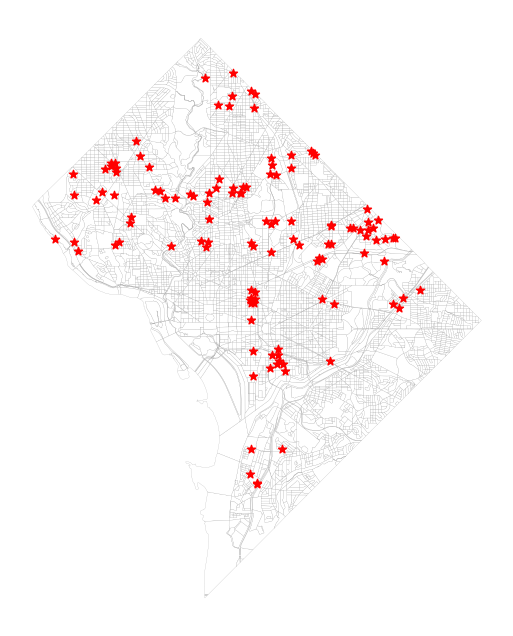

In [ ]:
'''ax = df.plot(edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("city_map")
plt.show()
ax = df.plot("transit_potential", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("transit_potential")
plt.show()
ax = df.plot("point_likelihood", edgecolor='black', facecolor='w', figsize=(8,8), linewidth=0.1)
ax.set_axis_off()
plt.savefig("point_likelihood")
plt.show()'''
ax = df.plot(edgecolor='grey', facecolor='w', figsize=(8,8), linewidth=0.1)
ax = df_points.plot(ax=ax, color='r', marker='*')
ax.set_axis_off()
plt.savefig("stations")


In [110]:
df

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,GEOIDFQ20,NAME20,MTFCC20,UR20,UACE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
0,24,031,701002,1010,240317010021010,1000000US240317010021010,Block1010,G5040,U,92242,S,59340,0,+39.0594169,-077.1757716,45,126,"POLYGON ((-77.17783 39.05929, -77.1778 39.0595..."
17,24,031,700317,1070,240317003171070,1000000US240317003171070,Block1070,G5040,R,None,S,787,674537,+39.1882159,-077.2837029,0,0,"POLYGON ((-77.29914 39.19383, -77.29857 39.194..."
19,24,031,700713,1001,240317007131001,1000000US240317007131001,Block1001,G5040,U,92242,S,144562,72362,+39.1627543,-077.1994613,329,802,"POLYGON ((-77.20513 39.16644, -77.20497 39.166..."
25,24,031,700317,1065,240317003171065,1000000US240317003171065,Block1065,G5040,R,None,S,276596,0,+39.1838548,-077.3087915,0,0,"POLYGON ((-77.31274 39.18391, -77.31268 39.184..."
34,24,031,700839,3002,240317008393002,1000000US240317008393002,Block3002,G5040,U,92242,S,28819,0,+39.1206673,-077.2003738,0,0,"POLYGON ((-77.20636 39.11792, -77.20579 39.118..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,11,001,009901,1009,110010099011009,1000000US110010099011009,Block1009,G5040,U,92242,S,10088,0,+38.8742069,-076.9616580,11,35,"POLYGON ((-76.96233 38.87401, -76.96233 38.874..."
6008,11,001,008701,2004,110010087012004,1000000US110010087012004,Block2004,G5040,U,92242,S,8269,0,+38.9178280,-077.0042975,43,107,"POLYGON ((-77.00509 38.91812, -77.00486 38.918..."
6009,11,001,000804,1011,110010008041011,1000000US110010008041011,Block1011,G5040,U,92242,S,9327,0,+38.9248067,-077.0928228,6,23,"POLYGON ((-77.09344 38.92454, -77.0934 38.9250..."
6010,11,001,000804,2009,110010008042009,1000000US110010008042009,Block2009,G5040,U,92242,S,76018,0,+38.9154911,-077.0974442,66,100,"POLYGON ((-77.10052 38.91899, -77.10045 38.918..."
